In [82]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt

### Image Segmentation
- 이미지에서 단순히 경계선을 추출하는 작업은 그냥 심층 신경망이나 한층의 컨볼루션 레이어 만으로도 충분히 가능한 작업이다.
- 그러나 의미 있는 부분, 예를 들면 물체의 테두리나 사람의 윤곽등을 추출하고 이미지를 의미있는 부분과 의미 없는 부분으로 분할하기 위해서는 학습을 해야 한다.
- 그리고 super resolution에 사용한 모델을 조금만 수정하면 이미지 분할에 사용이 가능하다.

**Oxford-IIT Pet 데이터 세트를 이용해서 이미지의 경계선, 내용, 외곽의 3가지로 분류하는 방법으로 이미지 분할 문제를 학습해 보고자 한다.**

- tensorflow dataset, 즉 tfds를 이용하면 저장된 데이터와 함께 라벨까지 같이 제공해 주어서 미리 준비된 데이터세트를 tensor Dataset의 형태로 묶어서 받을 수 있다는 장점이 존재한다.
- 그러나 아쉽게도 다운이 tfds로는 잘 되지 않아서 ```keras.utils.get_file(저장된 데이터의 이름, 다운로드 주소)```를 이용해서 이미지를 받았다.

**그래서 다른 데이터 셋을 썼는데, 이 데이터의 경우에는 이미지 마스킹이 3개의 경계로 된 것이 아니라 오히려 segmantic segmentation에 더 가까웠다.**  
- 마스킹이라는 것이 애초에 **이미지의 픽셀을 군집화**하는 것인데, 이 경우에는 하나의 물체/객체가 하나의 클래스로 묶여 있기 때문에 일반적으로 1 이상의 stride를 사용하는 CNN에서는 정보가 소실되기 쉽기 때문에(이미지 데이터를 모으는 과정에서) 오토인코더를 사용해서 학습을 한다.

In [2]:
image = tf.keras.utils.get_file("image","http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz")

In [ ]:
seg_mask = tf.keras.utils.get_file("segmentation_mask", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz")

- 이렇게 해서 이미지를 다운받아보고 싶었으나, 아무리 해도 리눅스 기반에서 작동하는 tar.gz파일의 압축을 푸는 것이 구글링을 해봐도 해결 방안을 찾기가 너무 어려웠다.
- 그래서 다른 데이터 셋을 찾아서 시도를 해보고자 한다.
- 이 데이터셋은 'MIT Scene Parsing Benchmark'에서 다운 받은 데이터로, 건물의 이미지와 이를 masking한 이미지가 존재한다.
    - 이제 이번 모델 설계의 목표는 우리가 train_dataset과 validation_dataset을 만들어서 학습을 하는데, 원본 이미지가 주어져도 객체와 주변 풍경 등이 구분이 갈 수 있을 정도로 학습하는 것이 목표이다.
    - masking되어 있는 이미지들은 이미지의 픽셀 정보가 몇가지로 한정되어 있으며, 중심부/외곽/객체 배경등에 따라 다른 픽셀값을 지니도록 조작한 이미지 데이터이다.

In [ ]:
tf.keras.utils.get_file("C:\\Users\\이지혜\\Desktop\\mask_image.zip",'https://groups.csail.mit.edu/vision/datasets/ADE20K/ADE20K_2016_07_26.zip',extract = True)

- 데이터를 원하는 저장소에 저장하는 과정까지는 했지만 안타깝게도 데이터가 압축된 파일이어서 이를 원격으로 압축 해제하는 것 까지는 하지 못했다.
- 그래서 수동으로 하느라 시간을 많이 잡아먹었다.

In [164]:
import pathlib
train_root = pathlib.Path('C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training')
all_train_path = list(train_root.glob('*/*/*'))

In [165]:
val_root = pathlib.Path('C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\validation')
all_val_path = list(val_root.glob('*/*/*'))

In [166]:
len(all_train_path), len(all_val_path)

(58486, 6423)

In [167]:
all_val_path[10:20]

[WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/abbey/ADE_val_00001001_parts_1.png'),
 WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/abbey/ADE_val_00001001_seg.png'),
 WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/access_road/ADE_val_00000003.jpg'),
 WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/access_road/ADE_val_00000003_atr.txt'),
 WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/access_road/ADE_val_00000003_parts_1.png'),
 WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/access_road/ADE_val_00000003_seg.png'),
 WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/access_road/ADE_val_00001002.jpg'),
 WindowsPath('C:/Users/이지혜/Desktop/mask_image/ADE20K_2016_07_26/images/validation/a/access_road/ADE_val_00001002_atr.txt'),
 WindowsPath('C:/Use

In [168]:
(str(all_val_path[3]).split('_')[-1]).split('.')

['seg', 'png']

In [169]:
real_train_path, mask_train_path, real_val_path, mask_val_path = [],[],[],[]
for i in all_train_path:
    temp = str(i)
    if temp.split('.')[-1] == 'jpg':
        real_train_path.append(temp)
    elif temp.split('.')[-1] == 'png':
        a = temp.split('_')[-1].split('.')
        if a[0] == 'seg':
            mask_train_path.append(temp)
            
for i in all_val_path:
    temp = str(i)
    if temp.split('.')[-1] == 'jpg':
        real_val_path.append(temp)
    elif temp.split('.')[-1] == 'png':
        a = temp.split('_')[-1].split('.')
        if a[0] == 'seg':
            mask_val_path.append(temp)

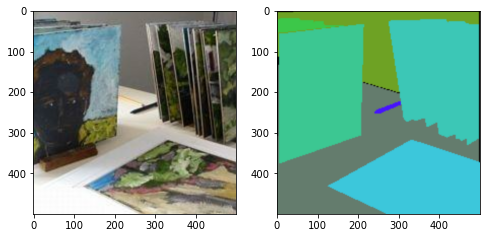

In [170]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
img = tf.io.read_file(real_train_path[640])
img = tf.image.decode_jpeg(img, channels = 3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (500,500))
plt.imshow(img)
plt.subplot(1,2,2)
img = tf.io.read_file(mask_train_path[640])
img = tf.image.decode_png(img, channels = 3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (500,500))
plt.imshow(img)

In [171]:
mask_train_path[:10]

['C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000970_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000971_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000972_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000973_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000974_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000975_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000976_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\abbey\\ADE_train_00000977_seg.png',
 'C:\\Users\\이지혜\\Desktop\\mask_image\\ADE20K_2016_07_26\\images\\training\\a\\a

In [172]:
len(real_train_path), len(mask_train_path)

(15417, 15417)

In [173]:
len(real_val_path), len(mask_val_path)

(1524, 1524)

In [174]:
train_index = np.random.randint(0,len(real_train_path), 300)
val_index = np.random.randint(0, len(real_val_path), 100)

In [175]:
real_train_path = real_train_path[500:1000]
mask_train_path = mask_train_path[500:1000]
real_val_path = real_val_path[200:300]
mask_val_path = mask_val_path[200:300]

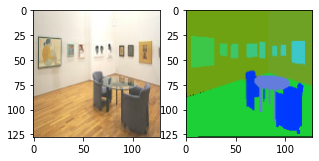

In [176]:
a,b = load_image(real_train_path[49]), load_image(mask_train_path[49])
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(a)
plt.subplot(1,2,2)
plt.imshow(b)

In [177]:
def load_image(image_dir):
    img = tf.io.read_file(image_dir)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128,128))
    return img

In [178]:
real_train_dataset = tf.data.Dataset.list_files(real_train_path)
real_train_dataset = real_train_dataset.map(load_real)
mask_train_dataset = tf.data.Dataset.list_files(mask_train_path)
mask_train_dataset = mask_train_dataset.map(load_mask)

In [179]:
real_val_dataset = tf.data.Dataset.list_files(real_val_path)
real_val_dataset = real_val_dataset.map(load_real)
mask_val_dataset = tf.data.Dataset.list_files(mask_val_path)
mask_val_dataset = mask_val_dataset.map(load_mask)

In [180]:
train_dataset = tf.data.Dataset.zip((real_train_dataset, mask_train_dataset))
val_dataset = tf.data.Dataset.zip((real_val_dataset, mask_val_dataset))

In [181]:
train_dataset = train_dataset.batch(8).repeat()
val_dataset = val_dataset.batch(1).repeat()

In [182]:
train_dataset, val_dataset

(<RepeatDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>,
 <RepeatDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>)

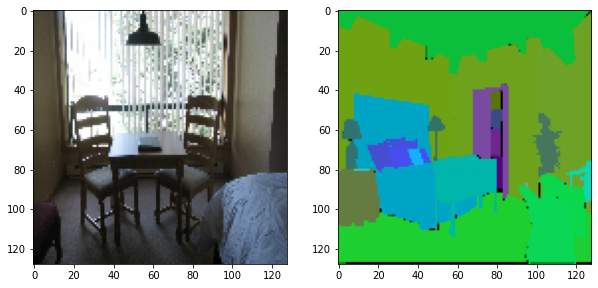

In [185]:
for img, mask in val_dataset.take(1):
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(img,axis = 0))
    
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(mask,axis = 0))
plt.show()

In [186]:
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.optimizers import Adam

In [19]:
def REDnet_seg(num_layers):
    conv_layers, residual_layers, deconv_layers = [],[],[]
    
    inputs = Input(shape = (None, None, 3))
    conv_layers.append(Conv2D(3, kernel_size = (3,3), padding= 'same', activation = 'relu'))
    
    for i in range(num_layers-1):
        conv_layers.append(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
        deconv_layers.append(Conv2DTranspose(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    
    deconv_layers.append(Conv2DTranspose(3, kernel_size = (3,3), padding = 'same', activation = 'softmax'))
    
    x = conv_layers[0](inputs)
    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i%2 == 0:
            residual_layers.append(x)
    for i in range(num_layers-1):
        if i%2 == 1:
            x = tf.keras.layers.Add()([x,residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x)
    
    x = deconv_layers[-1](x)
    
    model = Model(inputs = inputs, outputs = x)
    return model

In [23]:
model = REDnet_seg(15)
model.compile(loss= 'categorical_crossentropy', metrics = ['accuracy'], optimizer = tf.keras.optimizers.Adam(0.0001))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 84          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [24]:
histo = model.fit_generator(
   train_dataset, epochs = 20, validation_data = (val_dataset), steps_per_epoch = 300//16, validation_steps = 100)

Train for 18 steps, validate for 100 steps
Epoch 1/20
18/18 [==============================] - 928s 52s/step - loss: 1.1754 - accuracy: 0.5241 - val_loss: 1.1506 - val_accuracy: 0.6594
Epoch 2/20
18/18 [==============================] - 920s 51s/step - loss: 1.1399 - accuracy: 0.6458 - val_loss: 1.1307 - val_accuracy: 0.6687
Epoch 3/20
18/18 [==============================] - 933s 52s/step - loss: 1.1375 - accuracy: 0.6421 - val_loss: 1.1306 - val_accuracy: 0.6687
Epoch 4/20
18/18 [==============================] - 998s 55s/step - loss: 1.1374 - accuracy: 0.6452 - val_loss: 1.1287 - val_accuracy: 0.6688
Epoch 5/20
18/18 [==============================] - 962s 53s/step - loss: 1.1363 - accuracy: 0.6471 - val_loss: 1.1309 - val_accuracy: 0.6688
Epoch 6/20
18/18 [==============================] - 961s 53s/step - loss: 1.1375 - accuracy: 0.6554 - val_loss: 1.1300 - val_accuracy: 0.6688
Epoch 7/20
18/18 [==============================] - 950s 53s/step - loss: 1.1176 - accuracy: 0.6203 - val

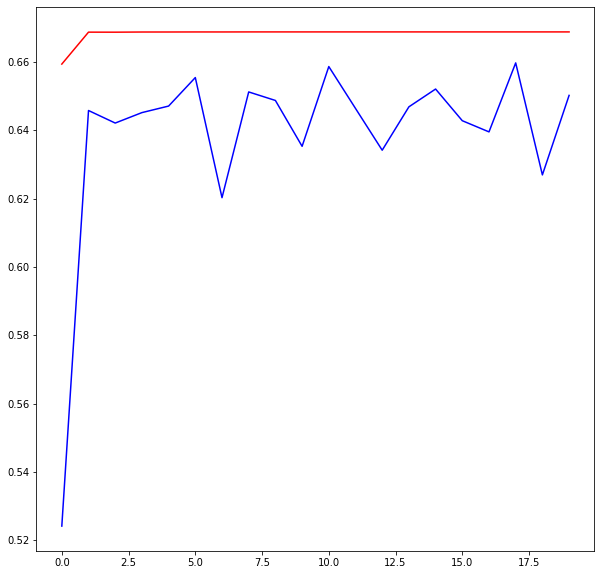

In [25]:
plt.figure(figsize = (10,10))
plt.plot(histo.history['accuracy'], 'b-')
plt.plot(histo.history['val_accuracy'], 'r-')
plt.show()

In [24]:
plt.figure(figsize = (12,12))
index = np.random.randint(301, 1000, 3)
idx = 1
for i in range(3):
    img = tf.io.read_file(real_train_path[index[i]])
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128,128))
    mask = tf.io.read_file(mask_train_path[index[i]])
    mask = tf.image.decode_jpeg(mask, channels = 3)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, (128,128))
    pred = model.predict(np.asarray(img).reshape(-1,128,128,3))
    plt.subplot(3,3,idx)
    plt.imshow(img)
    idx += 1
    plt.subplot(3,3,idx)
    plt.imshow(np.squeeze(pred,axis = 0))
    idx += 1
    plt.subplot(3,3,idx)
    idx+= 1
    plt.imshow(mask)
plt.show()

IndexError: list index out of range

<Figure size 864x864 with 0 Axes>

**생각했던 것 보다 성능이 좋지 않은 것 같다. 학습을 더 시키던가 학습 과정에서 loss에 문제가 있었을 것 같다. 이번에는 relu 대신에 elu 함수를 써보는 등의 방법을 사용해 보고자 한다. 또는 train데이터의 수를 늘리면 좋을 것 같다.  
아니면 loss함수를 sparse_categorical_crossentropy를 사용해야 하는 것일까??**

### 성능 향상을 위한 조정 후 학습

In [187]:
from tensorflow.keras.activations import elu
def REDnet_seg(num_layers):
    conv_layers, residual_layers, deconv_layers = [],[],[]
    
    inputs = Input(shape = (None, None, 3))
    conv_layers.append(Conv2D(3, kernel_size = (3,3), padding= 'same', activation = 'selu'))
    
    for i in range(num_layers-1):
        conv_layers.append(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'selu'))
        deconv_layers.append(Conv2DTranspose(64, kernel_size = (3,3), padding = 'same', activation = 'selu'))
    
    deconv_layers.append(Conv2DTranspose(3, kernel_size = (3,3), padding = 'same', activation = 'softmax'))
    
    x = conv_layers[0](inputs)
    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i%2 == 0:
            residual_layers.append(x)
    for i in range(num_layers-1):
        if i%2 == 1:
            x = tf.keras.layers.Add()([x,residual_layers.pop()])
            x = tf.keras.layers.Activation('selu')(x)
        x = deconv_layers[i](x)
    
    x = deconv_layers[-1](x)
    
    model = Model(inputs = inputs, outputs = x)
    return model
new_model = REDnet_seg(15)
new_model.compile(loss= 'categorical_crossentropy', metrics = ['accuracy'], optimizer = tf.keras.optimizers.Adam(0.0001))
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, None, None, 3 84          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 6 1792        conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, None, None, 6 36928       conv2d_31[0][0]                  
____________________________________________________________________________________________

1. categrical_crossentropy vs sparse_categorical_crossentropy
2. model.fit_generator() vs model.fit()

In [26]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 500, 500, 3), (None, 500, 500, 3)), types: (tf.float32, tf.float32)>

In [133]:
def display(display_list):
    plt.figure(figsize=(5, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        plt.show()
        
def show_predictions():
    for real, mask in train_dataset.take(1):
        display([real[0], mask[0],new_model.predict(real)[0]])
    
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()

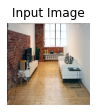

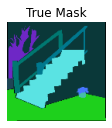

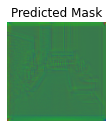

In [51]:
show_predictions()

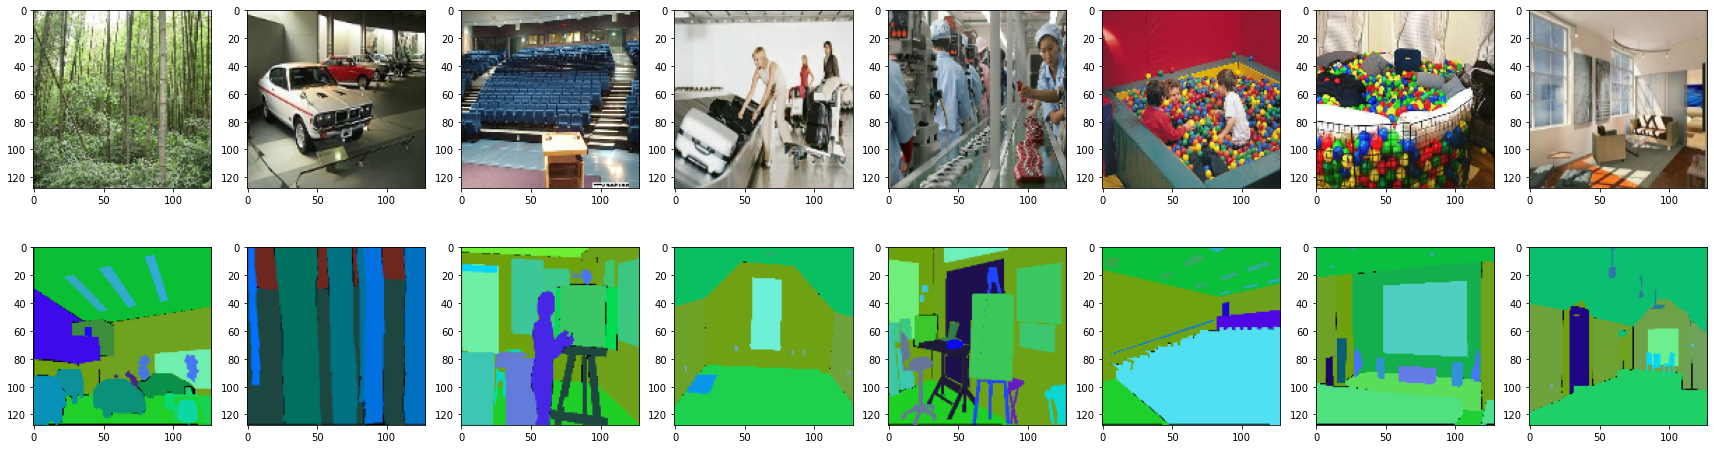

In [162]:
plt.figure(figsize = (30,8))
for (real, mask) in train_dataset.take(1):
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow((real[i]))
    for i in range(8):
        plt.subplot(2,8,i+9)
        plt.imshow(mask[i])

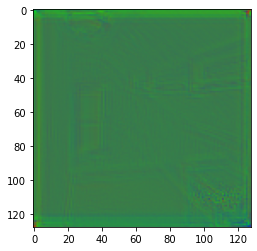

In [143]:
for real, mask in train_dataset.take(1):
    plt.imshow(new_model.predict(real)[3])

In [163]:
from tensorflow.keras.callbacks import EarlyStopping

In [190]:
histo = new_model.fit(
   train_dataset, epochs = 20, validation_data = val_dataset, steps_per_epoch = 500//8, 
    validation_steps = 100, callbacks = [EarlyStopping(monitor = 'val_accuracy', patience = 5)])

Train for 62 steps, validate for 100 steps
Epoch 1/20
62/62 [==============================] - 814s 13s/step - loss: 1.2463 - accuracy: 0.6962 - val_loss: 1.2151 - val_accuracy: 0.8035
Epoch 2/20
62/62 [==============================] - 827s 13s/step - loss: 1.2167 - accuracy: 0.7313 - val_loss: 1.2177 - val_accuracy: 0.8041
Epoch 3/20
62/62 [==============================] - 830s 13s/step - loss: 1.2115 - accuracy: 0.7396 - val_loss: 1.2010 - val_accuracy: 0.8046
Epoch 4/20
62/62 [==============================] - 833s 13s/step - loss: 1.2113 - accuracy: 0.7511 - val_loss: 1.2033 - val_accuracy: 0.8046
Epoch 5/20
62/62 [==============================] - 842s 14s/step - loss: 1.2056 - accuracy: 0.7450 - val_loss: 1.2109 - val_accuracy: 0.8048
Epoch 6/20
62/62 [==============================] - 736s 12s/step - loss: 1.2093 - accuracy: 0.7469 - val_loss: 1.2030 - val_accuracy: 0.8048
Epoch 7/20
62/62 [==============================] - 489s 8s/step - loss: 1.2085 - accuracy: 0.7419 - val_

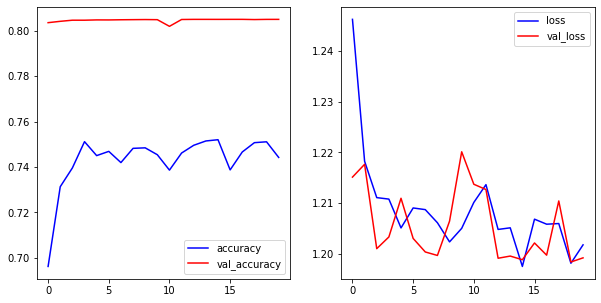

In [220]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(histo.history['accuracy'], 'b-', label = 'accuracy')
plt.plot(histo.history['val_accuracy'], 'r-',label = 'val_accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(histo.history['loss'], 'b-', label = 'loss')
plt.plot(histo.history['val_loss'], 'r-', label = 'val_loss')
plt.legend()
plt.show()

In [202]:
new_model.evaluate(val_dataset,steps = 100,verbose = 0)

[1.1990841817855835, 0.8050012]

### Accuracy = 80.50%

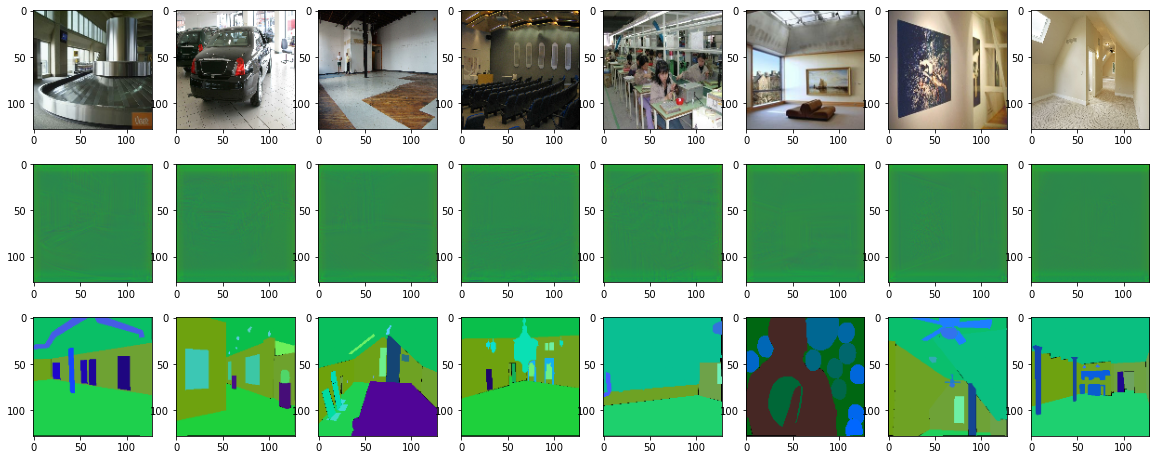

In [212]:
plt.figure(figsize = (20,8))
for real, mask in train_dataset.take(1):
    for i in range(8):
        plt.subplot(3,8,i+1)
        plt.imshow(real[i])
    pred = new_model.predict(real)
    for i in range(8):
        plt.subplot(3,8,i+9)
        plt.imshow(pred[i])
    for i in range(8):
        plt.subplot(3,8,i+17)
        plt.imshow(mask[i])
        
    

**자세히 predict된 데이터를 보면 좀 진한 부분의 형체가 확실히 위의 원본 이미지처엄 보인다. 원래 masking된 데이터가 초록 빛갈 이다 보니까 위와 같이 녹조를 띄는 듯한 모습을 보이는 것 같다. 절대 시각적으로 보면 잘 보이지는 않지만 그래도 이전에 relu를 이용했을 떄 보다 selu를 사용하니 훨씬 정확도나 손실 측면에서 향상했음을 알 수 있다.**